# Получение данных

In [103]:
import requests
import json
import time
import os
import pandas as pd
import datetime as dt

from typing import List, Any, Dict, Tuple
from tqdm.notebook import tqdm

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import seaborn as sns
import matplotlib
%pylab inline

plt.style.use('bmh')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


> Расширем немного для удобства 🐱‍💻

In [2]:
class ExtendedDict(dict):

    def batch_add(self, batch: Dict[str, Any]) -> None:
        """Обновление словаря списков по ключам - каждому списку добавляется значение с помощью append.
        Аналогично pd.concat, но для обычных dict.
        
        Обновляемые ключи должны содержать плоские списки!

        Args:
            target_dict (Dict[str, List[Any]]): 
            batch (Dict[str, Any]): данные для добавление в целевой словарь
        """
        for k, v in batch.items():
            self[k].append(v)

## География

In [3]:
def get_available_areas(url: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Получение географических регионов
    
    Args:
        url (str): эндпоинт api, используется для унификации функций
    
    Returns:
        Typle[pd.DataFrame, pd.DataFrame]: два датафрейма:
            * содержит название страны, id и количество областей ['name', 'country_id', 'num_areas']
            * содержит название области, id области, id страны, если есть, то id родительской области (-1, если нет)
                ['name', 'id', 'country_id', 'meta_area_id']
    """
    
    with requests.get(url) as req:
        raw_data = json.loads(req.content.decode())
    
    country_data = ExtendedDict({'name': [], 'id': [], 'num_areas': []})
    area_data = ExtendedDict({'name': [], 'id': [], 'country_id': [], 'meta_area_id': []})
    
    for country in raw_data:
        country_data.batch_add({
            'id': country['id'], 
            'name': country['name'], 
            'num_areas': len(country['areas'])
        })
        
        for area in country['areas']:
            area_data.batch_add({
                'id': area['id'], 
                'name': area['name'], 
                'country_id': country['id'], 
                'meta_area_id': -1
            })
            
            if len(area['areas']) > 0:
                for sub_area in area['areas']:
                    area_data.batch_add({
                        'id': sub_area['id'], 
                        'name': sub_area['name'], 
                        'country_id': country['id'], 
                        'meta_area_id': area['id']
                    })
        
        
    return pd.DataFrame(country_data), pd.DataFrame(area_data)

In [4]:
countries, areas = get_available_areas('https://api.hh.ru/areas')

In [5]:
areas[areas['name'] == "Москва"]

,name,id,country_id,meta_area_id
2107,Москва,1,113,-1


## Вакансии

> Выкачиваем по максимуму, ограничемся Москвой (hh может и забанить, если много лить😑)

Схема данных, которую раскладываем в датасет:
    
* id - если до прода дойдет - отдавать карточки работы😐
* name - название вакансии
* salary:
    * from - от
    * to - до
* published_at - размещена
* type [id] - если открта (оценка по времени поиска специалиста)
* employer 
    * id - id работодателя (потом можно дернуть интересующих с полной информацией)
    * name - имя работодателя
* snippet - основные данные
    * requirement - что нужно соискателю
    * responsibility - что будет делать
* schedule [id] - тип работы (офис, удаленка и т.д.)
* experience [id] - требуемый опыт
* employment [id] - тип занятости
* professional_roles - роли на работе (опять же, может пригодится) - хранить будем прям строкой

> Так как это учебная работа, соберем только по нескольким запросам:
    
* it
* ml engineer
* data engineer
* computer vision
* nlp
* neural networks

> Тут придется писать через класс, чтоб красиво)

In [6]:
class VacanciesDumper:
    """Класс для дампа вакансий с hh.ru"""
    
    def __init__(
        self, url: str, search_queries: List[str], area: str, prev_data: pd.DataFrame = None, timeout: int = 2
    ) -> None:
        """Инициализация класса

        Args:
            url (str): эндпоинт api, используется для унификации функций.
            search_queries (List[str]): список запросов (текстовых).
            area (str): id региона (см. табличку `areas`).
            prev_data (pd.DataFrame, Optional): если есть предыдущие данные, то обогощаем их, тут же MLOps, повторяемость,
                накопление, все дела. Defaults to None.
            timeout (int): после каждого запроса пауза в <timeout> мс, что б не банили. Defaults to 2.

        Returns:
            pd.DataFrame: содержит поля:
                id - если до прода дойдет - отдавать карточки работы😐 [id]
                name - название вакансии [vac_name]
                salary - зарплата:
                    from - от [salary_from]
                    to - до [salary_to]
                published_at - размещена [datetime]
                type [id] - если открта (оценка по времени поиска специалиста) [state]
                employer - работодатель:
                    id - id работодателя (потом можно дернуть интересующих с полной информацией) [employer_id]
                    name - имя работодателя [employer_name]
                snippet - основные данные
                    requirement - что нужно соискателю [requirement]
                    responsibility - что будет делать [responsibility]
                schedule [id] - тип работы (офис, удаленка и т.д.) [schedule]
                experience [name] - требуемый опыт [experience]
                employment [id] - тип занятости [employment]
                professional_roles - роли на работе (опять же, может пригодится) - хранить будем прям строкой [roles]
        """
        
        self.page = 0
        self.pages = None
        if prev_data is None:
            prev_data = pd.DataFrame(self.get_template())
        self.data = prev_data
        self.url = url
        self.area = area
        self.search_queries = search_queries
        self.timeout = timeout
        
        self.new_vacancies = 0
        self.drop_vacancies = 0
    
    @staticmethod
    def get_template() -> Dict[str, List[str]]:
        return ExtendedDict({
            'id': [], 
            'vac_name': [], 
            'salary_from': [], 
            'salary_to': [], 
            'datetime': [], 
            'state': [],
            'employer_id': [],
            'employer_name': [],
            'requirement': [],
            'responsibility': [],
            'schedule': [],
            'experience': [],
            'employment': [],
            'roles': []
        })
    
    @staticmethod
    def __log(message) -> None:
        ts = dt.datetime.now().strftime('%d.%m.%y %H:%M:%S')
        print(f'[{ts}] {message}')
    
    def __dump_page(self, query) -> None:
        """Дамп одной страницы"""
        
        with requests.get(self.url, {'area': self.area, 'per_page': 100, 'text': query, 'page': self.page}) as req:
            raw_data = json.loads(req.content.decode())
        
        _temp_dict = self.get_template()        
        for vac in raw_data['items']:
            if vac['id'] in self.data['id']:
                self.drop_vacancies += 1
            else:
                salary = {} if vac['salary'] is None else vac['salary']
                employer = {} if vac['employer'] is None else vac['employer']
                snippet = {} if vac['snippet'] is None else vac['snippet']
                schedule = {} if vac['schedule'] is None else vac['schedule']
                state = {} if vac['type'] is None else vac['type']
                experience = {} if vac['experience'] is None else vac['experience']
                employment = {} if vac['employment'] is None else vac['employment']
                    
                _temp_dict.batch_add({
                    'id': vac['id'], 
                    'vac_name': vac['name'], 
                    'salary_from': salary.get('from', None),
                    'salary_to': salary.get('from', None), 
                    'datetime': vac['published_at'], 
                    'state': state.get('id', None),
                    'employer_id': employer.get('id', None),
                    'employer_name': employer.get('id', None),
                    'requirement': snippet.get('requirement', None),
                    'responsibility': snippet.get('responsibility', None),
                    'schedule': schedule.get('id', None),
                    'experience': experience.get('name', None),
                    'employment': employment.get('id', None),
                    'roles': vac['professional_roles']
                })
                self.new_vacancies += 1
        
        self.data = pd.concat([self.data, pd.DataFrame(_temp_dict)], axis=0, ignore_index=True)
        
        self.page += 1
        if self.pages is None:
            self.pages = int(raw_data['pages'])
    
    def __dump_query(self, query) -> None:
        """Дамп одного запроса из `search_queries`"""
        
        self.page = 0
        self.__dump_page(query)
        time.sleep(self.timeout)
        
        while self.page < self.pages:
            self.__dump_page(query)
            self.__log(f'Запрос "{query}", страница {self.page}/{self.pages}')
            time.sleep(self.timeout)
    
    def dump(self) -> pd.DataFrame:
        """Начало дампа вакансий"""
        
        self.__log(f'Начинаю дамп {len(self.search_queries)} запросов')
        for query in self.search_queries:
            self.__dump_query(query)
            self.pages = None
            self.__log(f'Запрос "{query}" обработан!')
            
        self.__log(f'Дамп завершен! Новых записей: {self.new_vacancies}, отброшено: {self.drop_vacancies}')
        return self.data

In [7]:
dumper = VacanciesDumper(
    'https://api.hh.ru/vacancies', 
    search_queries=['it', 'ml engineer', 'data engineer', 'computer vision', 'nlp', 'neural networks'], 
    area='1'
)

In [8]:
hh_data = dumper.dump()

[21.10.23 19:04:50] Начинаю дамп 6 запросов
[21.10.23 19:04:52] Запрос "it", страница 3/20
[21.10.23 19:04:55] Запрос "it", страница 4/20
[21.10.23 19:04:57] Запрос "it", страница 5/20
[21.10.23 19:04:59] Запрос "it", страница 6/20
[21.10.23 19:05:02] Запрос "it", страница 7/20
[21.10.23 19:05:04] Запрос "it", страница 8/20
[21.10.23 19:05:06] Запрос "it", страница 9/20
[21.10.23 19:05:09] Запрос "it", страница 10/20
[21.10.23 19:05:11] Запрос "it", страница 11/20
[21.10.23 19:05:13] Запрос "it", страница 12/20
[21.10.23 19:05:16] Запрос "it", страница 13/20
[21.10.23 19:05:18] Запрос "it", страница 14/20
[21.10.23 19:05:20] Запрос "it", страница 15/20
[21.10.23 19:05:23] Запрос "it", страница 16/20
[21.10.23 19:05:25] Запрос "it", страница 17/20
[21.10.23 19:05:27] Запрос "it", страница 18/20
[21.10.23 19:05:30] Запрос "it", страница 19/20
[21.10.23 19:05:32] Запрос "it", страница 20/20
[21.10.23 19:05:35] Запрос "it", страница 21/20
[21.10.23 19:05:37] Запрос "it" обработан!
[21.10.2

# ML

> Так как цель практики MLops задача очень далека от практики. Если делать хорошо, то в срок точно ничего не сдать. Возможно, если будет время, можно аналитику покрутить и до ума довести. Может даже одностраничник сделать


Постановка задачи:

**По тексту `responsibility` предсказать зарплату (когорту) [1] и потребность в специалисте (когорта, чем меньше время существования вакансии тем выше потребность в текущее время) [2]**

Что сделать:
* два набора лейблов - зп и время онбординга (считаем, от текущего времени)
* токенизация
* моделька - вот тут прям лениво крутить трансформеры - просто скормим XGBoost 😑


> Посмотрим на распределения зарплат и времени онбординга

In [29]:
hh_data['onboard'] = \
    pd.to_datetime(dt.datetime.now().strftime('%Y-%m-%dT%H:%M:%S+0300')) - pd.to_datetime(hh_data['datetime'])

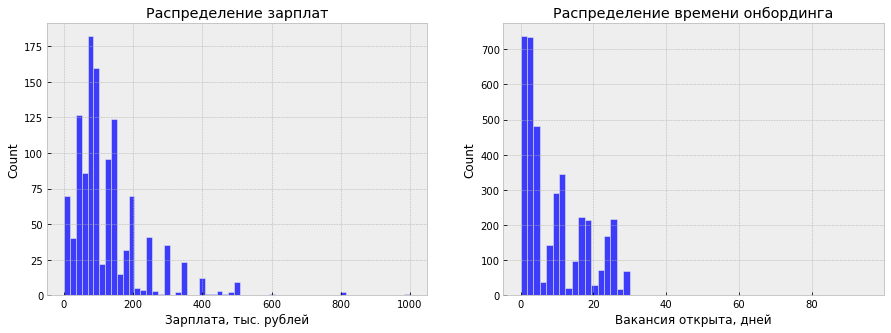

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(hh_data['salary_from'] / 1e3, ax=ax[0])
ax[0].set_xlabel('Зарплата, тыс. рублей')
ax[0].set_title('Распределение зарплат')
sns.histplot(hh_data['onboard'].dt.days, ax=ax[1])
ax[1].set_xlabel('Вакансия открыта, дней')
ax[1].set_title('Распределение времени онбординга')
plt.show()

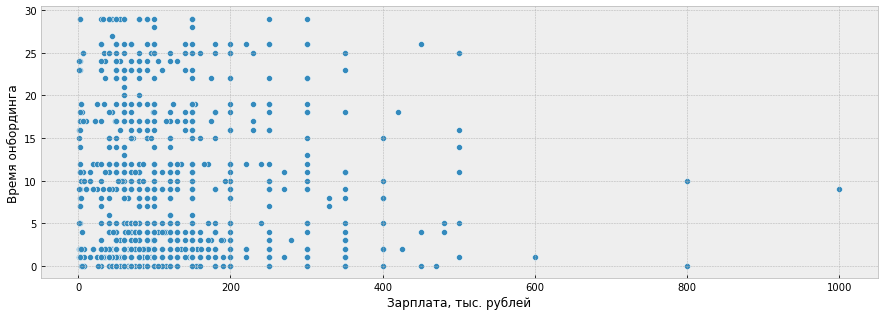

In [36]:
fig, ax = plt.subplots(1, figsize=(15, 5))
sns.scatterplot(x=hh_data['salary_from'] / 1e3, y=hh_data['onboard'].dt.days, ax=ax)
ax.set_xlabel('Зарплата, тыс. рублей')
ax.set_ylabel('Время онбординга')
plt.show()

> Особой зависимости нет, поэтому будем считать независимыми задачами

## Задача 1

In [37]:
from transformers import BertTokenizer

In [38]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

C:\Users\user\anaconda3\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Возьмем 300 токенов

In [64]:
def get_tokens(data: pd.Series) -> Tuple[np.ndarray, List[int]]:
    """Токинезация текста, без батчей
    
    Args:
        data (pd.Series) данные с описанием обязанностей
        
    Returns:
        (Tuple[np.ndarray, List[int]]): 
            * токенезированные данные с длинной 300
            * валидные индексы (пропускаем пустые)
    """
    
    data = data.to_list()
    result = []
    idx = []
    curr_id = 0
    for vac in tqdm(data):
        if vac is not None:
            result.append(
                tokenizer.encode(vac, max_length=300, truncation=True, padding='max_length')
            )
            idx.append(curr_id)
        curr_id += 1
        
    return np.array(result), idx

In [66]:
responsibility, idx = get_tokens(hh_data['responsibility'])
print(f"Валидных данных: {len(idx)}")

  0%|          | 0/3899 [00:00<?, ?it/s]

Валидных данных: 3859


Когорты по зарплате: 

|Когорта|Класс|
|---|---|
|None| 0|
|100|1|
|100 - 150|2|
|150 - 200|3|
| \> 200|4|

In [94]:
def get_salary_cohortes(salary: pd.Series, idx: List[int]) -> np.ndarray:
    """Получение когорт по зарплате
    
    Args:
        salary (pd.Series) данные о зарплате
        idx (List[int]) валидные индексы
        
    Returns:
        (np.ndarray): когорты зарплаты
    """
    results = []
    for curr_id in tqdm(idx):
        if np.isnan(salary[curr_id]):
            results.append(0)
        elif salary[curr_id] < 100_000:
            results.append(1)
        elif 100_000 < salary[curr_id] < 150_000:
            results.append(2)
        elif 150_000 < salary[curr_id] < 200_000:
            results.append(3)
        else:
            results.append(4)
    return np.array(results)

In [95]:
salary = get_salary_cohortes(hh_data['salary_from'], idx)

  0%|          | 0/3859 [00:00<?, ?it/s]

In [97]:
salary.shape, responsibility.shape

((3859,), (3859, 300))

> Модель

* спилт на трейн и тест
* обучение на трейне
* проверка на тесте

In [99]:
X_train, X_test, y_train, y_test = train_test_split(responsibility, salary, test_size=0.2, random_state=342)
print(f"Обучающих объектов: {X_train.shape[0]}, тестовых: {X_test.shape[0]}")

Обучающих объектов: 3087, тестовых: 772


In [101]:
model = XGBClassifier(
    n_estimators=50,
    max_depth=10,
    learning_rate=1e-3,
    objective="multi:softmax",
    num_class=5,
)
model.fit(X_train, y_train)

In [108]:
print("Результаты (ROC AUC):")
print(f"\tобучение {roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovo'):.3f}")
print(f"\tтест     {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo'):.3f}")

Результаты (ROC AUC):
	обучение 0.809
	тест     0.552


## Задача 2

Когорты по востребованности:
   
|Когорта|Класс|
|---|---|
|< 10| 0|
|10 - 20|1|
|\> 20|2|

In [116]:
def get_time_cohortes(time_data: pd.Series, idx: List[int]) -> np.ndarray:
    """Получение когорт по востребованности
    
    Args:
        salary (pd.Series) данные о времени
        idx (List[int]) валидные индексы
        
    Returns:
        (np.ndarray): когорты зарплаты
    """
    results = []
    for curr_id in tqdm(idx):
        if time_data[curr_id].days < 10:
            results.append(0)
        elif 10 < time_data[curr_id].days < 20:
            results.append(1)
        else:
            results.append(2)
    return np.array(results)

In [117]:
time_labels = get_time_cohortes(hh_data['onboard'], idx)

  0%|          | 0/3859 [00:00<?, ?it/s]

In [118]:
X_train, X_test, y_train, y_test = train_test_split(responsibility, time_labels, test_size=0.2, random_state=342)
print(f"Обучающих объектов: {X_train.shape[0]}, тестовых: {X_test.shape[0]}")

Обучающих объектов: 3087, тестовых: 772


In [119]:
model = XGBClassifier(
    n_estimators=50,
    max_depth=10,
    learning_rate=1e-3,
    objective="multi:softmax",
    num_class=5,
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_class=5, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [120]:
print("Результаты (ROC AUC):")
print(f"\tобучение {roc_auc_score(y_train, model.predict_proba(X_train), multi_class='ovo'):.3f}")
print(f"\tтест     {roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovo'):.3f}")

Результаты (ROC AUC):
	обучение 0.942
	тест     0.561
